# Лабораторная работа №5. Цифровой спектральный анализ.
Курс: лаборатория цифровой обработки сигналов, ФРКТ МФТИ
#  Модуль 4.  Коррелограммный метод оценки СПМ, оценка взаимной спектральной плотности мощности, спектральный анализ по неэквидистантным отсчетам. 

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
%matplotlib notebook

## Коррелограммный метод оценки СПМ (метод Блэкмана-Тьюки)

Корреляционный метод оценки СПМ основан на теореме Винера-Хинчина в дискретном варианте:

$$G(f)= \Delta t \sum \limits_{m=-\infty}^{\infty} R_x[m] \exp(-j 2\pi m f \Delta t).$$

Она заключается в том, что истинная спектральная плотность мощности $G(f)$ (СПМ) и автокорреляционная функция дискретного случайного процесса $R_x[m]$ связаны дискретным во времени преобразованием Фурье (ДВПФ). 

Для стационарного случайного процесса автокорреляционная функция (АКФ) (последовательность) $R_x[m]=M\{ x[k] x[k+m]\}$. Это функция от временного сдвига $m \in Z$.

---
**Пример.** Белый шум является дельта-коррелированным. Для его дискретного варианта 
$$R_x[m]=M\{ x[k] x[k+m]\}=\mathbf{1}[m] \sigma^2,$$
где $\sigma$ — стандартное отклонение,  $\sigma^2$ — дисперсия. Его спектральная плотность мощности (истинная) $G_x(f)=\Delta t \; \sigma^2$. 

---

Оценка по методу Блэкмана-Тьюки $\hat{G}_{BT}(f)$ по выборке длиной в $N$ отчетов определяется по формуле:
$$\hat{G}_{BT}(f)=\Delta t \sum \limits_{m=-(N_1-1)}^{N_1-1} \hat{R}_x[m] w[m]\exp(-j 2\pi m f \Delta t), $$
где 
* $N_1$ — ограничение на максимальный сдвиг в АКФ, $N_1=\left\lceil \dfrac{N}{10} \right\rceil$ (округление до ближайшего целого в сторону увеличения),
* $w[k]$ —  симметричная относительно нуля оконная функция длины $2N_1-1$,
* $\hat{R}_x[m]$ —  оценка автокорреляционной функции (коррелограмма) длиной в $2N_1-1$ отчетов, четная функция ($\hat{R}_x[m]=\hat{R}_x[-m]$ ). Используется смещенная либо несмещенная оценка АКФ.

* * Смещенная оценка АКФ вычисляется по формуле
$$\check{R}_x[m] = \dfrac{1}{N} \sum_{k=0}^{N-|m|-1} x[k] x[k+m], \; -(N_1-1)\le m \le N_1 - 1.$$

* * Несмещенная оценка АКФ вычисляется по формуле ($(N-|m|)$ — максимальное число ненулевых слагаемых в сумме)
$$\hat{R}_x[m] = \dfrac{1}{N-|m|} \sum_{k=0}^{N-|m|-1} x[k] x[k+m], \; -(N_1-1)\le m \le N_1 - 1.$$

Несмещенность оценки АКФ означает, что 
$$M\{ \hat{R}_x [m]\} = R_x[m].$$

Связь между смещенной и несмещенной оценкой:

$$\check{R}_x[m]={\dfrac{N-|m|}{N} \hat{R}_x[m]}$$.

При $N>>N_1 > |m|$ смещение невелико: $\check{R}_x[m]  \approx \hat{R}_x[m]$. 

Для того, чтобы оценка СПМ была неотрицательной, следует использовать смещенную оценку АКФ с окном, ДВПФ которого не принимает отрицательных значений (например, окно Бартлетта). 

**Пример**. Рассмотрим случайный процесс вида 
$$x_{сл}[k]=a_1 \sin \left( 2 \pi \dfrac{f_0}{f_s} k\right) + e[k],$$
где $a_1=5$, $f_0=2$ кГц, $f_s=10$ кГц, $e[k]$ — дискретный белый шум с дисперсией $\sigma^2$. 

In [4]:
fs=10000
f0=2000
a1=5
N=1024
k=np.arange(N)
x=a1*np.sin(2*np.pi*f0/fs*k)+np.random.normal(scale=8, size=N)

In [5]:
N1 = int(np.ceil(N/10))
N1

103

Вычисление смещенной оценки АКФ для $0 \le m \le N_1 -1$
$$\check{R}_x[m] = \dfrac{1}{N} \sum_{k=0}^{N-|m|-1} x[k] x[k+m], \; -(N_1-1)\le m \le N_1 - 1.$$

In [6]:
def auto_correlation(x, N1, mode='biased'):
    Rx = signal.correlate(x, x) / len(x)
    lag = np.arange(-(len(x)-1), len(x))
    return Rx[np.logical_and(lag<=N1-1, lag>=0)]

In [7]:
Rx = auto_correlation(x, N1, mode='biased')
plt.figure(figsize=[8, 3])
plt.tight_layout()
plt.stem(np.arange(len(Rx)), Rx, linefmt='', markerfmt='.')
plt.title("Коррелограмма")
plt.xlabel('lag m')
plt.ylabel('${{\\overset{\\smile}{R}}_{x}}_x[m]$')
plt.grid()
# plt.xlim([3000, 3050])
# plt.ylim([0, 0.1])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

Оценка $\hat{G}_{BT}(f)$
$$\hat{G}_{BT}(f)=\Delta t \sum \limits_{m=-(N_1-1)}^{N_1-1} \hat{R}_x[m] w[m]\exp(-j 2\pi m f \Delta t), $$
за счет симметрии $\hat{R}_x[m]=\hat{R}_x[-m]$ может быть представлена в виде

$${{\hat{G}}_{BT}}(f)=\Delta \text{ }\!\!~\!\!\text{ }t\left( \text{ }\!\!~\!\!\text{ }2\sum\limits_{m=0}^{{{N}_{1}}-1}{\text{ }\!\!~\!\!\text{ }}\left( {{{\hat{R}}}_{x}}[m]\text{ }\!\!~\!\!\text{ }w[m]\cos (2\pi mf\Delta \text{ }\!\!~\!\!\text{ }t) \right)-{{{\hat{R}}}_{x}}[0] \right)\text{ }\!\!~\!\!\text{ }$$

Для дискретной сетки частот $f_n=f_s \dfrac{ n}{N}$ сумма в этом выражении представлет ничто иное, как действительную часть коэффициэнтов ДПФ:
$${{\hat{G}}_{BT}}({{f}_{n}})=\Delta t\left(2\sum\limits_{m=0}^{{{N}_{1}}-1}\left( {{{\hat{R}}}_{x}}[m]w[m]\cos \frac{2\pi mn}{{{N}_\text{FFT}}} \right)-{{{\hat{R}}}_{x}}[0] \right)$$

In [8]:
def  blackman_tukey_estimator(x, window='bartlett', Nfft=None, auto_correlation_mode='biased', fs=1):
    N = len(x)
    N1 = int(np.ceil(N/10))
    if Nfft is None:
        Nfft=max(2**12, N)
    window = signal.get_window(window, 2*N1-1, fftbins=False)
    Rx = auto_correlation(x, N1, mode=auto_correlation_mode) * window[N1-1:2*N1:1]
    return fs*np.arange(Nfft)/Nfft, (2*np.fft.fft(Rx, Nfft).real - Rx[0])/fs

In [9]:
help(signal.get_window)

Help on function get_window in module scipy.signal.windows._windows:

get_window(window, Nx, fftbins=True)
    Return a window of a given length and type.
    
    Parameters
    ----------
    window : string, float, or tuple
        The type of window to create. See below for more details.
    Nx : int
        The number of samples in the window.
    fftbins : bool, optional
        If True (default), create a "periodic" window, ready to use with
        `ifftshift` and be multiplied by the result of an FFT (see also
        :func:`~scipy.fft.fftfreq`).
        If False, create a "symmetric" window, for use in filter design.
    
    Returns
    -------
    get_window : ndarray
        Returns a window of length `Nx` and type `window`
    
    Notes
    -----
    Window types:
    
    - `~scipy.signal.windows.boxcar`
    - `~scipy.signal.windows.triang`
    - `~scipy.signal.windows.blackman`
    - `~scipy.signal.windows.hamming`
    - `~scipy.signal.windows.hann`
    - `~scipy.signa

In [10]:
f, P_BT = blackman_tukey_estimator(x, window='bartlett', fs=fs)

In [11]:
plt.figure(figsize=[8, 3])
#plt.stem(f, P_BT, 'b', 'b.')
plt.plot(f, P_BT)
plt.xlim([0, fs/2])
plt.xlabel('Частота, Гц')
plt.ylabel('Оценка СПМ, Bт/Гц')
plt.title('$w[m]$ - окно Бартлетта')
plt.grid()
plt.tight_layout()
#plt.savefig('psd_BT2.svg')
plt.show()

<IPython.core.display.Javascript object>

In [12]:
f, P_BT = blackman_tukey_estimator(x, window='boxcar', fs=fs)

In [17]:
plt.figure(figsize=[8, 3])
#plt.stem(f, P_BT, 'b', 'b.')
plt.plot(f, P_BT)
plt.xlim([0, fs/2])
plt.xlabel('Частота, Гц')
plt.ylabel('Оценка СПМ, Bт/Гц')
plt.title('$w[m]$ - прямоугольное окно')
plt.grid()
plt.tight_layout()
#plt.savefig('psd_BT1.svg')
plt.show()

<IPython.core.display.Javascript object>

$w[k]$ —  симметричная относительно нуля оконная функция, а значит его ДВПФ принимает только действительные значения. Для того, чтобы оценка СПМ была неотрицательной, следует использовать смещенную оценку АКФ с окном $w[k]$, ДВПФ которого не принимает отрицательных значений (например, окно Бартлетта).

In [15]:
def window_plot(window='bartlett', N1=10):
    w = signal.get_window(window, 2*N1-1, fftbins=False)
    plt.figure(figsize=[8, 6])
    
    M=2**10
    nu, W = np.fft.fftshift(np.fft.fftfreq(M, d=1)), np.fft.fftshift(np.fft.fft(w, M))
    W=W*np.exp(2j*np.pi*nu*(N1-1))
    print(W.size)
    plt.subplot(2, 1, 1)
    plt.title("Симметричное окно %s" %window)
    plt.stem(np.arange(-N1+1, N1, 1), w)
    plt.xticks(ticks=np.arange(-N1+1, N1, 1))
    plt.ylabel("$w[k]$")
    plt.xlabel("$k$")
    plt.subplot(2, 1, 2)
    plt.title("ДВПФ симметричного окна %s" %window)
    plt.plot(nu, W.real)
    plt.ylabel("$W(\\nu)$")
    plt.xlabel("$\\nu$")
    plt.grid()
    plt.tight_layout()
    plt.show()

In [16]:
window_plot(window='boxcar')

<IPython.core.display.Javascript object>

1024


<IPython.core.display.Javascript object>


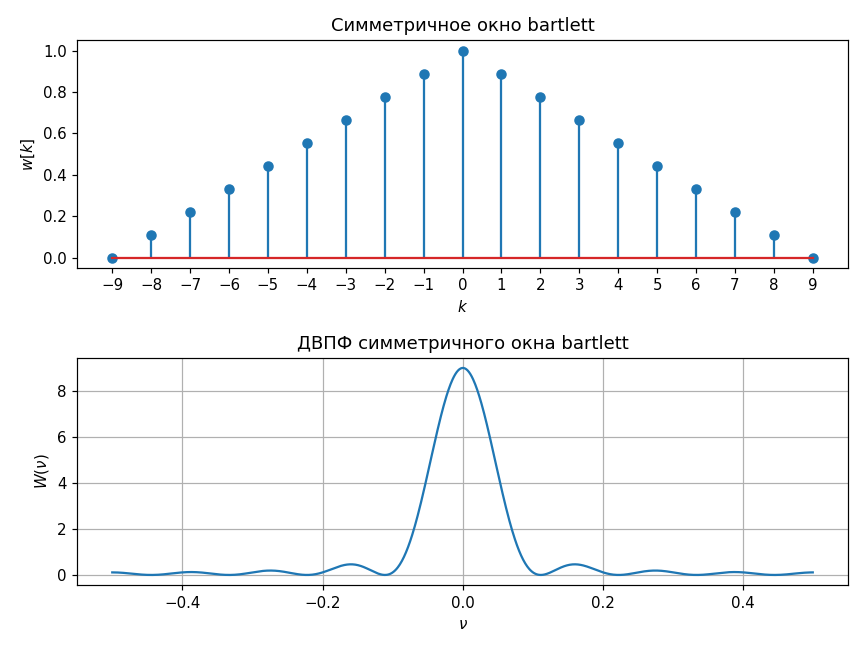

1024


In [28]:
window_plot(window='bartlett')

## Оценка взаимной спектральной плотности мощности

Автокорреляционная функция (АКФ) (последовательность) для случайного процесса $x[k]$
$$R_{x}[m]=r_{xx}[m]=M\{ x[k] x[k+m]\}.$$ 
Это функция от временного сдвига $m \in Z$. 

По теореме Виннера-Хинчина 
$$G_{xx}(f)= \Delta t \sum \limits_{m=-\infty}^{\infty} r_{xx}[m] \exp(-j 2\pi m f \Delta t).$$

Взаимная (кросс-) корреляционная функция для случайных процессов (действительных) $x[k]$ и $y[k]$ определяется как 
$$r_{xy}[m]=M\{ x[k] y[k+m]\}.$$ 

Для взаимной спектральной плотности может не выполняться равенство $r_{xy}[-m]=r^*_{xy}[m]$.

Через нее определяется  и взаимная (кросс-) спектральная плотность мощности для двух стационарных случайных процессов $x[k]$ и $y[k]$:
$$G_{xy}(f)= \Delta t \sum \limits_{m=-\infty}^{\infty} r_{xy}[m] \exp(-j 2\pi m f \Delta t).$$

Для взаимной СПМ может не выполняться равенство $r_{xy}[-m]=r^*_{xy}[m]$, а значит взаимная спектральная плотность мощности является комплекснозначной функцией в общем виде. Однако для нее выполняется свойство $G_{xy}(f)=G^*_{yx}(f)$.

**Коррелограммный метод** оценивания взаимной спектральной плотности мощности имеет форму:
$$\hat{G}_{xy}(f)=\Delta t \sum \limits_{m=-(N_1-1)}^{N_1-1} \hat{r}_{xy}[m] w[m]\exp(-j 2\pi m f \Delta t), $$

где 
* $N_1$ — ограничение на максимальный сдвиг в кросс-корреляционной функции,
* $w[k]$ —  симметричная относительно нуля оконная функция длины $2N_1-1$,
* $\hat{r}_{xy}[m]$ —  оценка кросс-корреляционной функции длиной в $2N_1-1$ отчетов.

**Метод Уэлча** (`signal.csd`) для оценки взаимной СПМ заключается в следующем. 

Рассмотрим этот способ для $P$ сегментов по $D$ отсчетов, при сдвиге между соседними сегментами $S\le D$.

Сначала $N$—точечные последовательности сегментируются взвешиваются окном:

$$x^{(p)}[k]=w[k]x[k+pS],$$

$$y^{(p)}[k]=w[k]y[k+pS],$$

где $0 \le k \le D-1$, $0 \le p \le P-1$, по которым вычисляются выборочные кросс-спектральные оценки сегментов:

$${\tilde{P}}^{(P)}_{xy}(f)=\frac{\Delta t}{U}{{X}^{(p)}}(f){{\left( {{Y}^{(p)}}(f) \right)}^{*}},$$
где 
$${{X}^{(p)}}(f)=\sum\limits_{k=0}^{D-1}{{{x}^{(p)}}}[k]\exp \left( -j2\pi f\ k\Delta t \right),$$
$${{Y}^{(p)}}(f)=\sum\limits_{k=0}^{D-1}{{{y}^{(p)}}}[k]\exp \left( -j2\pi f\ k\Delta t \right).$$
$$ U= \sum_{k=0}^{D-1} w^2[k].$$

Окончательная оценка кросс-СПМ $ \hat{P}_{xy} (f)$ строится путем усреднения по всем сегментам. 

$$ \hat{P}_{xy} (f)= \dfrac{1}{P} \sum_{p=0}^{P-1} {\tilde{P}}^{(P)}_{xy}(f). $$

In [17]:
fs=10000
f0=2000
f1=3000
a1=4
a2=5
N=1024*64
k=np.arange(N)

x=a1*np.sin(2*np.pi*f0/fs*k) + a2*np.sin(2*np.pi*f1/fs*k) + np.random.normal(scale=20, size=N)
y=a1*np.sin(2*np.pi*f0/fs*k+np.pi/4) +np.random.normal(scale=20, size=N)

<IPython.core.display.Javascript object>


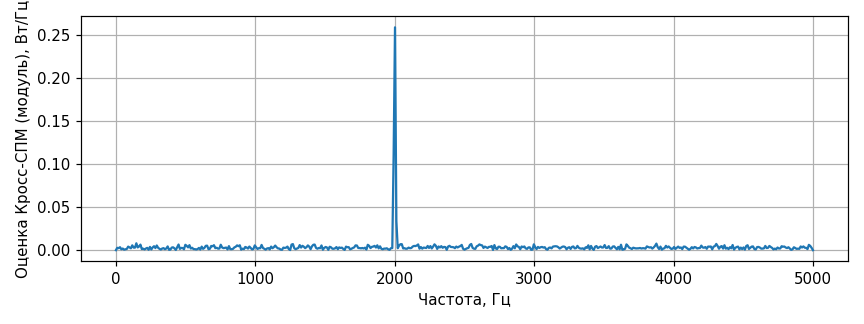

In [18]:
f, Pxy = signal.csd(x, y, fs, nperseg=x.size//64)
plt.figure(figsize=[8, 3])
# plt.semilogy(f, np.abs(Pxy))
plt.plot(f, np.abs(Pxy)/2)
plt.xlabel('Частота, Гц')
plt.ylabel('Оценка Кросс-СПМ (модуль), Bт/Гц')
plt.grid()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


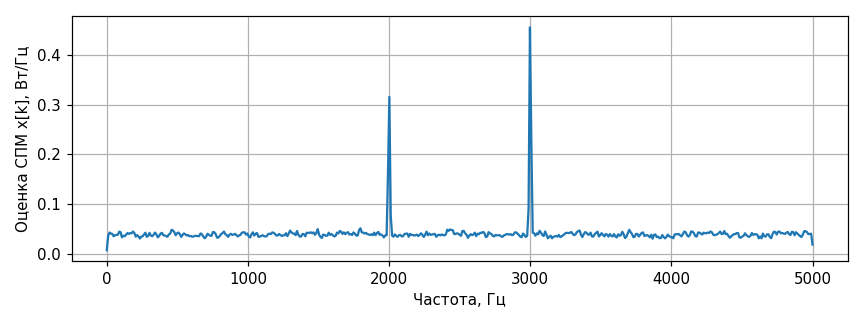

In [19]:
f, Pxy = signal.csd(x, x, fs, nperseg=x.size//64)
plt.figure(figsize=[8, 3])
#plt.semilogy(f, np.abs(Pxy))
plt.plot(f, np.abs(Pxy)/2)
plt.xlabel('Частота, Гц')
plt.ylabel('Оценка СПМ x[k], Bт/Гц')
plt.grid()
plt.tight_layout()
plt.show()

Для взаимной спекральной плотности может не выполняться равенство $r_{xy}[-m]=r^*_{xy}[m]$, а значит взаимная спектральная плотность мощности является комплеснозначной функцией в общем виде. Однако для нее выполняется свойство $G_{xy}(f)=G^*_{yx}(f)$.

In [20]:
f, Pxy = signal.csd(x, y, fs, nperseg=x.size//64)
f, Pyx = signal.csd(y, x, fs, nperseg=x.size//64)
dif = (Pxy-np.conjugate(Pyx))
max(abs(dif))

0.0

## Спектральный анализ по неэквидистантным отсчетам (периодограммы Ломба-Скаргла)

In [18]:
fs=10000
f0=2000
f1=3000
a1=4
a2=5
k=np.arange(N)

M=10000
t=np.linspace(0, 50/fs, M)

r = np.random.rand(M)
t = t[r >= 0.95]
N=t.size

# 1 случай - анализ во временной области возможен
# x=a1*np.sin(2*np.pi*f0*t) + a2*np.sin(2*np.pi*f1*t) + np.random.normal(scale=0.5, size=N)
# 2 случай - анализ во временной области невозможен
x=a1*np.sin(2*np.pi*f0*t) + a2*np.sin(2*np.pi*f1*t) + np.random.normal(scale=7, size=N)

<IPython.core.display.Javascript object>


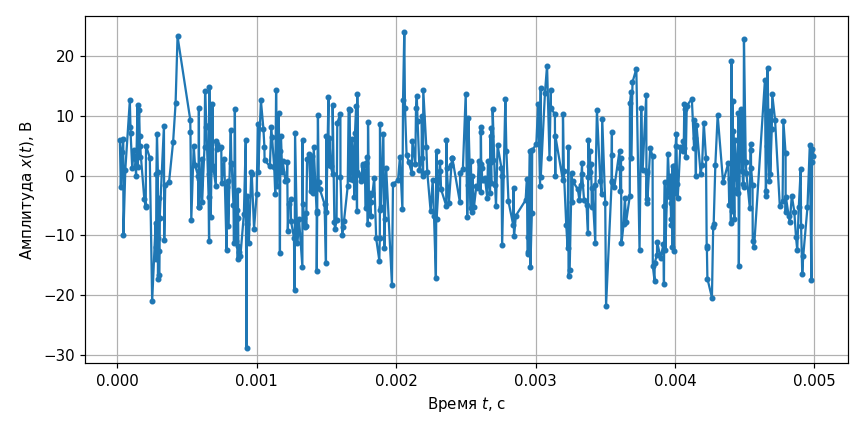

In [22]:
plt.figure(figsize=[8, 4])
plt.plot(t, x, '.-')
plt.xlabel('Время $t$, с')
plt.ylabel('Амплитуда $x(t)$, В')
plt.tight_layout()
plt.grid()
plt.show()

In [21]:
w=np.linspace(fs/2**14, fs/2, 2**12)*2*np.pi

Периодограммы Ломба-Скаргла реализованы библиотечными функциями
* в ```scipy``` - ```scipy.signal.lombscargle```
* в ```astropy``` - ```astropy.timeseries.LombScargle``` https://docs.astropy.org/en/stable/timeseries/lombscargle.html

In [22]:
pgram = signal.lombscargle(t, x, w, normalize=True)

* ```t``` - отчеты времени
* ```x``` - отчеты сигнала
* ```w``` - частоты в рад/с

<IPython.core.display.Javascript object>


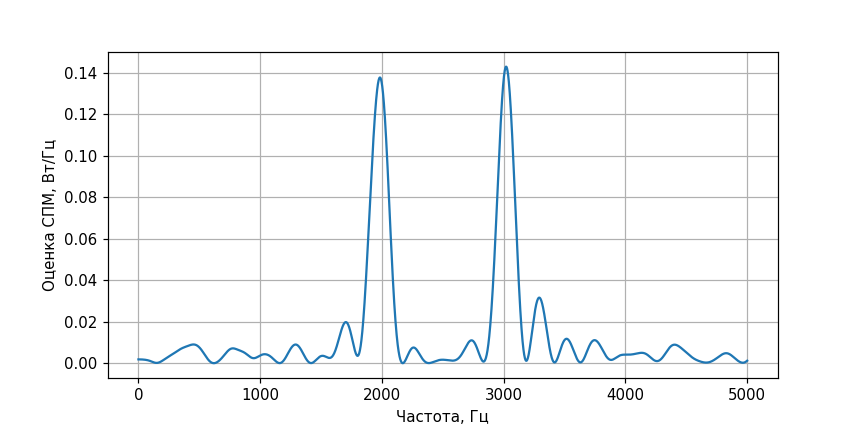

In [25]:
plt.figure(figsize=[8, 4])
plt.plot(w/(2*np.pi), pgram)
plt.xlabel('Частота, Гц')
plt.ylabel('Оценка СПМ, Bт/Гц')
plt.grid()
plt.show()

### LS-спектры


---
Материал представлен в соотвествии с учебным пособием

[4]  Витязев В.В. Анализ неравномерных временных рядов: Учеб. пособие. — СПб.: СПбГУ, 2001. — 68 с.


---



До этого мы изучили периодограммы для равномерных рядов. Теперь посмотрим спектры неравномерных рядов. Для построения оценки спектральной плотности мощности  неравномерных рядов используется аппроксимация временного ряда гармонической функцией.
Пусть задан временной ряд 
	$$\begin{matrix}
   {{x}_{k}}=x\left( {{t}_{k}} \right), & k=0,1,\ldots ,N-1,  \\
\end{matrix} $$	
на произвольном множестве  временных отсчетов ${{t}_{k}}$. В качестве модели этого временного ряда будем использовать следующую функцию
	$$f\left( t \right)={{a}_{1}}{{\varphi }_{1}}\left( t \right)+{{a}_{2}}{{\varphi }_{2}}\left( t \right)	$$
где $\begin{matrix}
   {{\varphi }_{1}}\left( t \right)=\cos \left( \omega t \right), & {{\varphi }_{2}}\left( t \right)=\sin \left( \omega t \right)  \\
\end{matrix}$.
Определим невязку аппроксимации
	$${{\varepsilon }_{k}}={{x}_{k}}-f\left( {{t}_{k}} \right)$$	
и найдем коэффициенты для  ряда $f(t)$ из условия
	$${{\left\| \varepsilon  \right\|}^{2}}=\min ,$$	
где будут использованы следующие обозначения
	$$\left( \phi ,\varphi  \right)=\frac{1}{N}\sum\limits_{k=0}^{N-1}{\phi \left( {{t}_{k}} \right)\varphi \left( {{t}_{k}} \right),}$$	
	$${{\left\| \varphi  \right\|}^{2}}=\left( \varphi ,\varphi  \right).$$	
Для определения коэффициентов получим следующую систему нормальных уравнений
	$$\left[ \begin{matrix}
   {{\left\| {{\varphi }_{1}} \right\|}^{2}} & \left( {{\varphi }_{1}},{{\varphi }_{2}} \right)  \\
   \left( {{\varphi }_{2}},{{\varphi }_{1}} \right) & {{\left\| {{\varphi }_{2}} \right\|}^{2}}  \\
\end{matrix} \right]\left[ \begin{matrix}
   {{a}_{1}}  \\
   {{a}_{2}}  \\
\end{matrix} \right]=\left[ \begin{matrix}
   \left( x,{{\varphi }_{1}} \right)  \\
   \left( x,{{\varphi }_{2}} \right)  \\
\end{matrix} \right],$$	
решение имеет следующий вид:
	$$\left[ \begin{matrix}
   {{a}_{1}}  \\
   {{a}_{2}}  \\
\end{matrix} \right]=\frac{1}{\Delta }\left[ \begin{matrix}
   {{\left\| {{\varphi }_{2}} \right\|}^{2}} & -\left( {{\varphi }_{1}},{{\varphi }_{2}} \right)  \\
   -\left( {{\varphi }_{2}},{{\varphi }_{1}} \right) & {{\left\| {{\varphi }_{1}} \right\|}^{2}}  \\
\end{matrix} \right]\left[ \begin{matrix}
   \left( x,{{\varphi }_{1}} \right)  \\
   \left( x,{{\varphi }_{2}} \right)  \\
\end{matrix} \right],$$	
где $\Delta ={{\left\| {{\varphi }_{1}} \right\|}^{2}}{{\left\| {{\varphi }_{2}} \right\|}^{2}}-{{\left( {{\varphi }_{1}},{{\varphi }_{2}} \right)}^{2}}.$
Вычислим теперь величину
	$${{E}_{\min }}={{\left\| \varepsilon  \right\|}^{2}}={{\left\| x \right\|}^{2}}-\sum\limits_{i=1}^{2}{{{a}_{i}}\left( x,{{\varphi }_{i}} \right)}$$
и введем функцию
	$$P\left( \omega  \right)={{\left\| x \right\|}^{2}}-{{E}_{\min }}\left( \omega  \right)\ge 0,$$
где ${{E}_{\min }}\left( \omega  \right)$ имеет смысл минимума квадрата нормы невязки, а ${{\left\| x \right\|}^{2}}$ представляет собой дисперсию ряда.
Очевидно, что значение функции $P\left( \omega  \right)$ будет резко возрастать только при совпадении частот модельного ряда $\omega$ с частотами гармонических компонент заданного временного ряда ${{x}_{k}}$. Поскольку эта оценка основана на методе наименьших квадратов, ее по предложению Ломба (1976)  называют 
LS-спектром (LS – Least Squares). Окончательная формула имеет следующий вид:
	$$P\left( \omega  \right)=\frac{1}{2}\sum\limits_{i=1}^{2}{{{a}_{i}}\left( x,{{\varphi }_{i}} \right)}.$$
Рассмотрим конкретные представления LS-спектров.

### LS-спектр Барнинга

Подставив решение в формулу для вычисления LS-спектра.  Получим следующее аналитическое выражение, обозначаемое $B\left( \omega  \right)$:
	$$B\left( \omega  \right)=\frac{1}{2}\frac{{{\left\| {{\varphi }_{1}} \right\|}^{2}}{{\left( x,{{\varphi }_{2}} \right)}^{2}}+{{\left\| {{\varphi }_{2}} \right\|}^{2}}{{\left( x,{{\varphi }_{1}} \right)}^{2}}-2\left( {{\varphi }_{1}},{{\varphi }_{2}} \right)\left( x,{{\varphi }_{1}} \right)\left( x,{{\varphi }_{2}} \right)}{{{\left\| {{\varphi }_{1}} \right\|}^{2}}{{\left\| {{\varphi }_{2}} \right\|}^{2}}-{{\left( {{\varphi }_{1}},{{\varphi }_{2}} \right)}^{2}}},$$
где ${{\left\| {{\varphi }_{1}} \right\|}^{2}},\ \ {{\left\| {{\varphi }_{2}} \right\|}^{2}},\ \ \left( {{\varphi }_{1}},{{\varphi }_{2}} \right),\ \ \left( x,{{\varphi }_{1}} \right),\ \ \left( x,{{\varphi }_{2}} \right),$ выражаются в соответствии с формулами рассмотренными выше.


### LS-спектр Ломба

Для описания статистических свойств LS-спектра желательно иметь для него представление в виде суммы двух величин. Это можно сделать разными способами. Один из них был предложен Ломбом (1976). Суть этого метода заключается в том, что для каждой модельной частоты $\omega$ отсчеты ${{t}_{k}}$ смещают на величину $\tau \left( \omega  \right)$. Введем новые отсчеты времени
	$$\begin{matrix}
   {{{\bar{t}}}_{k}}={{t}_{k}}-\tau \left( \omega  \right), & k=0,1,\ldots ,N-1,  \\
\end{matrix}$$	
и наложим на величину $\left( {{\varphi }_{1}},{{\varphi }_{2}} \right)$ условие 
	$$\left( {{\varphi }_{1}},{{\varphi }_{2}} \right)=\frac{1}{2}\sum\limits_{k=0}^{N-1}{\sin \left( \omega \left[ {{t}_{k}}-\tau \left( \omega  \right) \right] \right)\cos \left( \omega \left[ {{t}_{k}}-\tau \left( \omega  \right) \right] \right)}=0.$$
Отсюда находим $\tau \left( \omega  \right)$:
	$$\tau \left( \omega  \right)=\frac{1}{2\omega }\text{arctg}\left( \frac{\sum\limits_{k=0}^{N-1}{\sin 2\omega {{t}_{k}}}}{\sum\limits_{k=0}^{N-1}{\cos 2\omega {{t}_{k}}}} \right).$$
При сделанных предположениях для LS-спектра имеем следующее представление:
	$$L\left( \omega  \right)=\frac{1}{2}\left[ \frac{{{\left( x,{{{\bar{\varphi }}}_{1}} \right)}^{2}}}{{{\left\| {{{\bar{\varphi }}}_{1}} \right\|}^{2}}}+\frac{{{\left( x,{{{\bar{\varphi }}}_{2}} \right)}^{2}}}{{{\left\| {{{\bar{\varphi }}}_{2}} \right\|}^{2}}} \right],$$
где ${{\bar{\varphi }}_{1}}\left( t \right)=\cos \left( \omega {{{\bar{t}}}_{k}} \right),$    ${{\bar{\varphi }}_{2}}=\sin \left( \omega {{{\bar{t}}}_{k}} \right).$


### Модификация Скаргла

Развивая идеи Ломба и желая сохранить информацию о фазе излучаемых колебаний, Скаргл (1982)  ввел в рассмотрение специальный вид дискретного преобразования Фурье:
	$$FT\left( \omega  \right)=\frac{\exp \left( -j\omega {{t}_{0}} \right)}{\sqrt{2}}\left[ \frac{\left( x,{{{\bar{\varphi }}}_{1}} \right)}{\left\| {{{\bar{\varphi }}}_{1}} \right\|}+j\frac{\left( x,{{{\bar{\varphi }}}_{2}} \right)}{\left\| {{{\bar{\varphi }}}_{2}} \right\|} \right].$$
Легко понять, что периодограмма Ломба связана с преобразованием Скаргла следующим образом:
	$$L\left( \omega  \right)={{\left| FT\left( \omega  \right) \right|}^{2}}.$$


## Список литературы

[1] Солонина, А. И. Цифровая обработка сигналов в зеркале MATLAB : учебное пособие / А. И. Солонина .— Санкт-Петербург : БХВ-Петербург, 2021.

[2] Марпл-мл., С. Л.Цифровой спектральный анализ и его приложения : [учеб. пособие для вузов] / С. Л. Марпл-мл. ; пер. с англ. О. И. Хабарова, Г. А. Сидоровй под ред. И. С. Рыжака .— М. : Мир, 1990.

[3] Оппенгейм, А. Цифровая обработка сигналов: [учеб. пособие для вузов] / А. Оппенгейм, Р. Шафер ; пер. с англ. под ред. С. Ф. Боева .— 3-е изд., испр. — Москва : Техносфера, 2019.

[4]  Витязев В.В. Анализ неравномерных временных рядов: Учеб. пособие. — СПб.: СПбГУ, 2001. — 68 с.

[5]  VanderPlas J. T. Understanding the lomb–scargle periodogram //The Astrophysical Journal Supplement Series. – 2018. – Vol. 236. – №. 1. – P. 16.

Книги [1], [2], [3] есть в библиотеке МФТИ.